In [1]:
import os
import numpy as np # type: ignore
import xarray as xr # type: ignore
import pandas as pd # type: ignore
from pathlib import Path
from rra_tools.shell_tools import mkdir # type: ignore

In [34]:
model = "MIROC6"  # Default value for model if not provided
scenario = "ssp245"
variant = "r1i1p1f1"  # Default value for variant if not provided
year = 2020
covariate = "flood_fraction"

OUTPUT_ROOT = Path("/mnt/team/rapidresponse/pub/flooding/output/fldfrc")

In [52]:
def standardize_flooding_fraction(model: str, scenario: str, variant: str, covariate: str, year: int):
    print(f"Standardizing flooding fraction for {model}, {scenario}, {variant}, {year}...")
    input_file = OUTPUT_ROOT / scenario / model / f"flood_fraction_{year}.nc"
    output_file = OUTPUT_ROOT / scenario / model / f"flood_fraction_{year}_std.nc"

    if not input_file.exists():
        print(f"Input file {input_file} does not exist. Skipping...")
        return

    # Read the daily flooding fraction data
    ds = xr.open_dataset(input_file)
    da = ds[covariate].values  # shape: (days, lat, lon)
    
    # Set all negative values to NaN
    da[da < 0] = np.nan
    
    # Create a copy for standardization
    da_std = da.copy()
    
    # Get dimensions
    days, height, width = da.shape
    
    # Process each pixel (lat, lon) separately to handle all-NaN cases
    for y in range(height):
        for x in range(width):
            pixel_values = da[:, y, x]
            # Skip if all values are NaN
            valid_values = pixel_values[~np.isnan(pixel_values)]
            if len(valid_values) > 0:
                min_value = np.min(valid_values)
                # Subtract minimum from all days for this pixel
                da_std[:, y, x] = da[:, y, x] - min_value
                # Set negative values to zero
                negative_mask = da_std[:, y, x] < 0
                da_std[negative_mask, y, x] = 0

    # Save the standardized flooding fraction as a new NetCDF file
    ds[covariate] = (('time', 'lat', 'lon'), da_std)

    # Define compression and data type encoding
    encoding = {
        covariate: {"zlib": True, "complevel": 5, "dtype": "float32"},  # Apply compression to data variable
        "lon": {"dtype": "float32", "zlib": True, "complevel": 5},  # Compress longitude
        "lat": {"dtype": "float32", "zlib": True, "complevel": 5},  # Compress latitude
        "time": {"dtype": "int32", "zlib": True, "complevel": 5, "units": f"days since {year}-01-01"}  # Compress time
    }
    ds.to_netcdf(output_file, format="NETCDF4", engine="netcdf4", encoding=encoding)
    
    print(f"Standardized flooding fraction saved to {output_file}")

    # Close the dataset to free up resources
    ds.close()


In [53]:
# Test the function out and read in both the original and the standardized flooding fraction bricks afterwards to compare
standardize_flooding_fraction(model, scenario, variant, covariate, year)


Standardizing flooding fraction for MIROC6, ssp245, r1i1p1f1, 2020...
Standardized flooding fraction saved to /mnt/team/rapidresponse/pub/flooding/output/fldfrc/ssp245/MIROC6/flood_fraction_2020_std.nc


Set negative values to NaN in original flooding fraction.


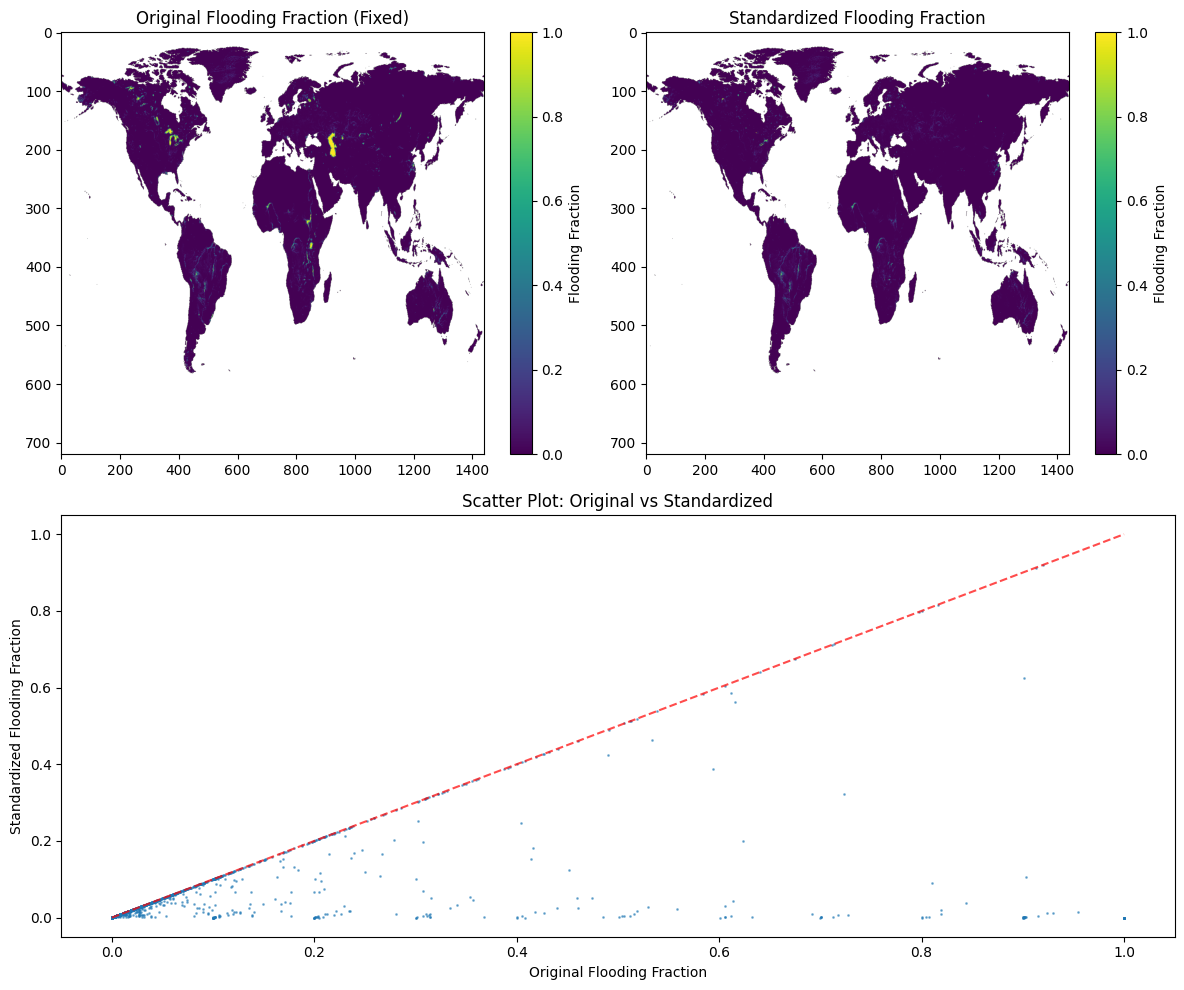

Number of valid data points: 10000
Correlation coefficient: 0.5587


In [55]:
# Set negative values to NaN in the original flooding fraction
if original_fldfrc is not None:
    original_fldfrc_fixed = original_fldfrc.copy()
    original_fldfrc_fixed[original_fldfrc_fixed < 0] = np.nan
    print("Set negative values to NaN in original flooding fraction.")
else:
    print("Original flooding fraction not available.")

# Compare the original (with negatives fixed) and standardized flooding fraction
if 'original_fldfrc_fixed' in locals() and standardized_fldfrc is not None:
    plt.figure(figsize=(12, 10))
    
    # First subplot for original data (fixed)
    plt.subplot(2, 2, 1)
    plt.title("Original Flooding Fraction (Fixed)")
    plt.imshow(original_fldfrc_fixed[0], cmap='viridis', aspect='auto')
    plt.colorbar(label='Flooding Fraction')
    
    # Second subplot for standardized data
    plt.subplot(2, 2, 2)
    plt.title("Standardized Flooding Fraction")
    plt.imshow(standardized_fldfrc[0], cmap='viridis', aspect='auto')
    plt.colorbar(label='Flooding Fraction')
    
    # Third subplot for scatter plot
    plt.subplot(2, 1, 2)
    plt.title("Scatter Plot: Original vs Standardized")
    
    # Flatten arrays and remove NaN values for scatter plot
    orig_flat = original_fldfrc_fixed.flatten()
    std_flat = standardized_fldfrc.flatten()
    
    # Only use points where both arrays have valid data
    mask = ~np.isnan(orig_flat) & ~np.isnan(std_flat)
    
    # If there are valid points, create scatter plot
    if np.any(mask):
        # Sample points to prevent overcrowding (max 10,000 points)
        if np.sum(mask) > 10000:
            sample_indices = np.random.choice(np.where(mask)[0], 10000, replace=False)
            sample_mask = np.zeros_like(mask)
            sample_mask[sample_indices] = True
            mask = mask & sample_mask
        
        plt.scatter(orig_flat[mask], std_flat[mask], alpha=0.5, s=1)
        plt.xlabel('Original Flooding Fraction')
        plt.ylabel('Standardized Flooding Fraction')
        
        # Add a diagonal reference line
        max_val = max(np.nanmax(orig_flat), np.nanmax(std_flat))
        min_val = min(np.nanmin(orig_flat), np.nanmin(std_flat))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
    else:
        plt.text(0.5, 0.5, 'No valid data points for comparison', 
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate statistics for valid data points
    if np.any(mask):
        print(f"Number of valid data points: {np.sum(mask)}")
        print(f"Correlation coefficient: {np.corrcoef(orig_flat[mask], std_flat[mask])[0, 1]:.4f}")
else:
    print("Cannot create scatter plot due to missing data.")